# 1. MediaPipe

## Instalação das bibliotecas

In [1]:
!pip install opencv-python==4.6.0.66
!pip install mediapipe==0.8.11
!pip install numpy==1.22.3


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import cv2
import mediapipe as mp
import numpy as np
import time

Objetos usados para identificar a face

In [17]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

## Lendo a webcam

Os parâmetros, **min_detection_confidence** e **min_tracking_confidence**, especificam, respectivamente, o valor mínimo de confiança de detecção da face e o valor mínimo de confiança para o rastreamento dos pontos na face. Podemos parametrizar o valor de confiança entre 0.0 e 1.0. O valor padrão para ambos é 0.5.

In [9]:
# Instancia a leitura da webcam principal
cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        # lê a webcam
        sucesso, frame = cap.read()

        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue


        # Captura as marcações da face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)


        # o Try é usado pois se não houver rostos o programa irá gerar um erro
        try:
            # Marcação dos pontos faciais encontrados
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
        except:
            pass


        # Mostra o frame lido da webcam
        cv2.imshow("Camera", frame)

        # interrompe o while quando o 'c' é apertado
        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

# solta a webcam e fecha as janelas abertas
cap.release()
cv2.destroyAllWindows()

# 2. Mapeando os Olhos

onde encontrar as coordenadas da face

In [18]:
for face_landmarks in saida_facemesh.multi_face_landmarks:
    face = face_landmarks
    for id_coord, coord_xyz in enumerate(face.landmark):
        print(coord_xyz)

x: 0.5613765716552734
y: 0.6509678959846497
z: -0.021135713905096054

x: 0.5537794828414917
y: 0.6056457161903381
z: -0.048264093697071075

x: 0.5584079027175903
y: 0.6176794171333313
z: -0.022998325526714325

x: 0.5456572771072388
y: 0.5621277689933777
z: -0.038588013499975204

x: 0.5524064302444458
y: 0.5924549698829651
z: -0.05249573290348053

x: 0.5522925853729248
y: 0.5744801163673401
z: -0.050472985953092575

x: 0.5536669492721558
y: 0.5294502377510071
z: -0.031026333570480347

x: 0.49812057614326477
y: 0.5307338833808899
z: 0.017871499061584473

x: 0.5528534650802612
y: 0.4976274371147156
z: -0.02881752885878086

x: 0.5514214038848877
y: 0.47970083355903625
z: -0.03291982784867287

x: 0.5485004186630249
y: 0.4095253050327301
z: -0.030170001089572906

x: 0.5621492862701416
y: 0.6578822731971741
z: -0.01930299587547779

x: 0.5632801055908203
y: 0.6628071069717407
z: -0.015551221556961536

x: 0.5644815564155579
y: 0.6645190119743347
z: -0.010957760736346245

x: 0.5651959776878357
y

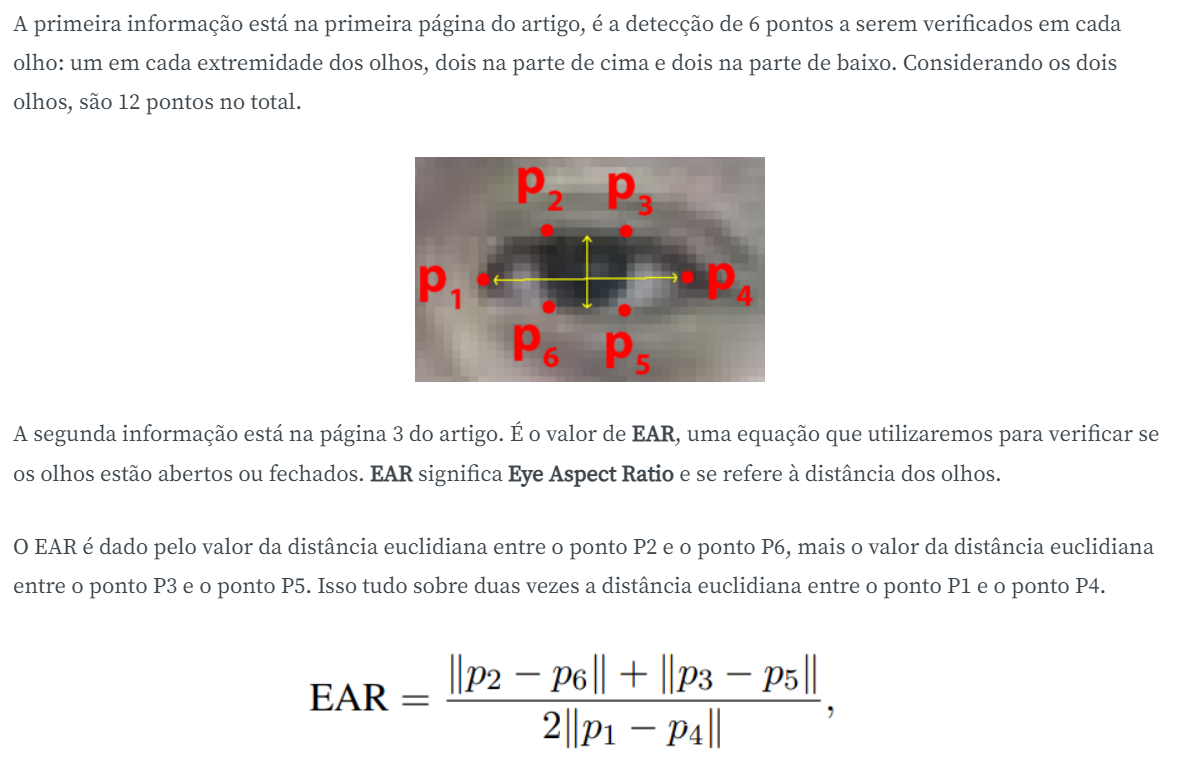

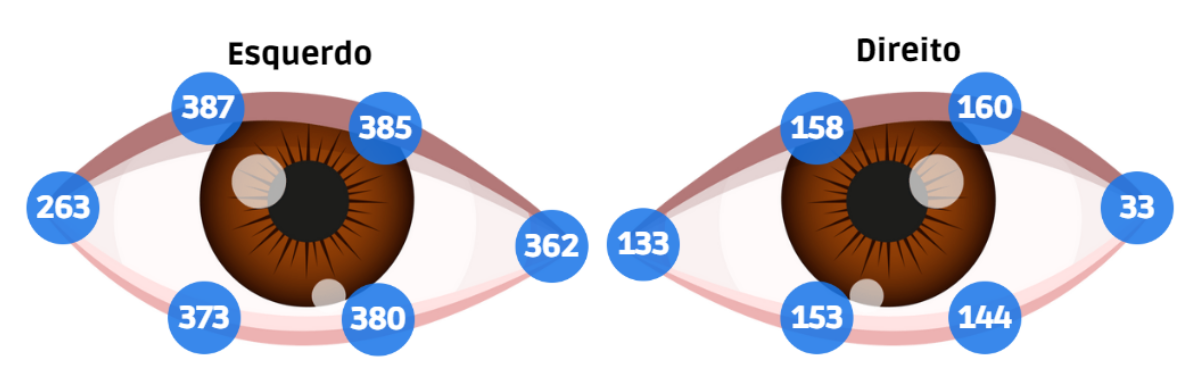

In [19]:
p_olho_esq = [385, 380, 387, 373, 362, 263]
p_olho_dir = [160, 144, 158, 153, 33, 133]


In [20]:
p_olhos = p_olho_esq+p_olho_dir
p_olhos


[385, 380, 387, 373, 362, 263, 160, 144, 158, 153, 33, 133]

In [21]:
def calculo_ear(face, p_olho_dir, p_olho_esq):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])

        face_esq = face[p_olho_esq, :]
        face_dir = face[p_olho_dir, :]

        ear_esq = (np.linalg.norm(face_esq[0]-face_esq[1])+np.linalg.norm(face_esq[2]-face_esq[3]))/(2*(np.linalg.norm(face_esq[4]-face_esq[5])))
        ear_dir = (np.linalg.norm(face_dir[0]-face_dir[1])+np.linalg.norm(face_dir[2]-face_dir[3]))/(2*(np.linalg.norm(face_dir[4]-face_dir[5])))
    except:
        ear_esq = 0.0
        ear_dir = 0.0
    
    media_ear = (ear_esq+ear_dir)/2
    return media_ear

os pontos precisam estar em pixels, porém eles vem normalizados.  
Então será necessário transformar para pixels!

In [6]:
ear_limiar = 0.38
dormindo = 0

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue

        comprimento, largura, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
                
                face = face_landmarks.landmark
                for id_coord, coord_xyz in enumerate(face):
                    # identifica os pontos dos olhos e pinta eles de azul
                    if id_coord in p_olhos:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                # calcula o ear para esta face
                ear = calculo_ear(face, p_olho_dir, p_olho_esq)
                # apresenta na tela o valor do EAR
                cv2.rectangle(frame, (0,1),(290,140),(58,58,55),-1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
    
                
                # contando o tempo que o olho ficou fechado
                if ear < ear_limiar:
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    dormindo = 1

                if dormindo == 1 and ear >= ear_limiar:
                    dormindo = 0

                t_final = time.time()
    
                # calcula o tempo de olho fechado
                tempo = (t_final - t_inicial) if dormindo == 1 else 0.0

                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80),
                                        cv2.FONT_HERSHEY_DUPLEX,
                                        0.9, (255, 255, 255), 2)

                # gera alerta se ficar de olho fechado por mais de x segundos
                if tempo >= 1.5:
                    cv2.rectangle(frame, (30, 400), (610, 452), (109, 233, 219), -1)
                    cv2.putText(frame, f"Muito tempo com olhos fechados!", (80, 435),
                                    cv2.FONT_HERSHEY_DUPLEX,
                                    0.85, (58,58,55), 1)

        except:
            pass

        cv2.imshow("Camera", frame)

        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

cap.release()
cv2.destroyAllWindows()

# 03. Identificando a boca

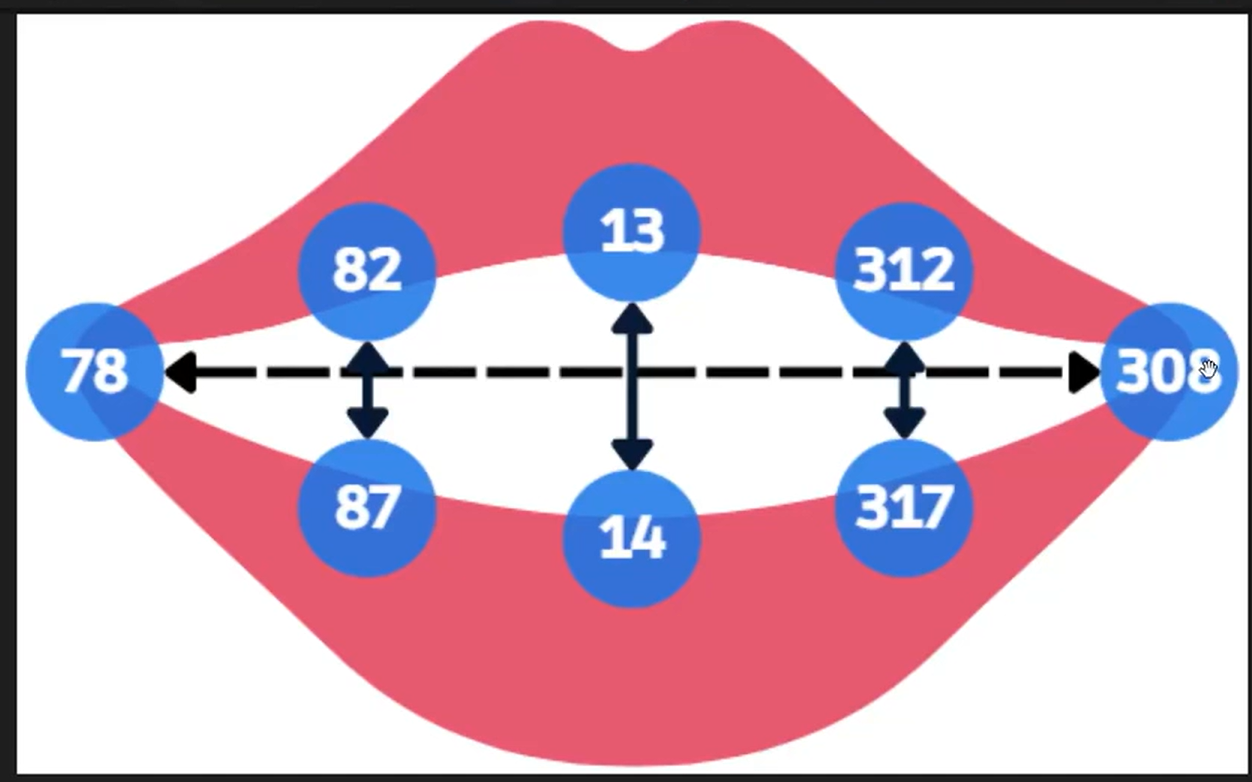

![image.png](attachment:image.png)

In [24]:
def calculo_mar(face,p_boca):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_boca = face[p_boca,:]

        mar = (np.linalg.norm(face_boca[0]-face_boca[1])+np.linalg.norm(face_boca[2]-face_boca[3])+np.linalg.norm(face_boca[4]-face_boca[5]))/(2*(np.linalg.norm(face_boca[6]-face_boca[7])))
    except:
        mar = 0.0

    return mar


In [22]:
p_boca = [82, 87, 13, 14, 312, 317, 78, 308]

In [25]:
ear_limiar = 0.38
mar_limiar = 0.2
dormindo = 0

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue

        comprimento, largura, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
                
                face = face_landmarks.landmark
                for id_coord, coord_xyz in enumerate(face):
                    if id_coord in p_olhos:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                    if id_coord in p_boca:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                ear = calculo_ear(face, p_olho_dir, p_olho_esq)
                cv2.rectangle(frame, (0,1),(290,140),(58,58,55),-1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
                
                mar = calculo_mar(face, p_boca)
                cv2.putText(frame, f"MAR: {round(mar, 2)} {'Aberto' if mar>=mar_limiar else 'Fechado'}", (1, 50),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
    
                
                if ear < ear_limiar and mar < mar_limiar:
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    dormindo = 1

                if (dormindo == 1 and ear >= ear_limiar) or (ear <= ear_limiar and mar >= mar_limiar):
                    dormindo = 0

                t_final = time.time()
    
                tempo = (t_final - t_inicial) if dormindo == 1 else 0.0

                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80),
                                        cv2.FONT_HERSHEY_DUPLEX,
                                        0.9, (255, 255, 255), 2)

                if tempo >= 1.5:
                    cv2.rectangle(frame, (30, 400), (610, 452), (109, 233, 219), -1)
                    cv2.putText(frame, f"Muito tempo com olhos fechados!", (80, 435),
                                    cv2.FONT_HERSHEY_DUPLEX,
                                    0.85, (58,58,55), 1)

        except:
            pass

        cv2.imshow("Camera", frame)

        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

cap.release()
cv2.destroyAllWindows()

# 04. Detecção de sono

In [30]:
ear_limiar = 0.38
mar_limiar = 0.2
dormindo = 0
contagem_piscadas = 0

c_tempo = 0
contagem_temporaria = 0
contagem_lista = []

t_piscadas = time.time()

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue

        comprimento, largura, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
                
                face = face_landmarks.landmark
                for id_coord, coord_xyz in enumerate(face):
                    if id_coord in p_olhos:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                    if id_coord in p_boca:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                ear = calculo_ear(face, p_olho_dir, p_olho_esq)
                cv2.rectangle(frame, (0,1),(290,140),(58,58,55),-1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
                
                mar = calculo_mar(face, p_boca)
                cv2.putText(frame, f"MAR: {round(mar, 2)} {'Aberto' if mar>=mar_limiar else 'Fechado'}", (1, 50),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
                
                cv2.putText(frame, f"Piscadas: {contagem_piscadas}", (1, 120),
                                                cv2.FONT_HERSHEY_DUPLEX,
                                                0.9, (109, 233, 219), 2)
    
                
                if ear < ear_limiar and mar < mar_limiar:
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    contagem_piscadas = contagem_piscadas+1 if dormindo == 0 else contagem_piscadas
                    dormindo = 1

                if (dormindo == 1 and ear >= ear_limiar) or (ear <= ear_limiar and mar >= mar_limiar):
                    dormindo = 0

                t_final = time.time()
    
                tempo = (t_final - t_inicial) if dormindo == 1 else 0.0

                tempo_decorrido = t_final - t_piscadas

                if tempo_decorrido >= (c_tempo+1):
                    c_tempo = tempo_decorrido
                    piscadas_ps = contagem_piscadas-contagem_temporaria
                    contagem_temporaria = contagem_piscadas
                    contagem_lista.append(piscadas_ps)
                    contagem_lista = contagem_lista if (len(contagem_lista)<=60) else contagem_lista[-60:]

                piscadas_pm = 15 if (len(contagem_lista)) <= 60 else contagem_lista[-60, :]

                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80),
                                        cv2.FONT_HERSHEY_DUPLEX,
                                        0.9, (255, 255, 255), 2)

                if piscadas_pm < 10 or tempo>=1.5:
                    cv2.putText(frame, f"Pode ser que voce esteja com sono,", (60, 420),
                                        cv2.FONT_HERSHEY_DUPLEX, 
                                        0.85, (0,0,255), 1)
                    cv2.putText(frame, f"considere descansar.", (180, 450),
                                        cv2.FONT_HERSHEY_DUPLEX, 
                                        0.85, (0,0,255), 1)

        except:
            pass

        cv2.imshow("Camera", frame)

        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

cap.release()
cv2.destroyAllWindows()